# Classificação de dados com a competição do Titanic

O objetivo deste notebook é criar um modelo utilizando Machine Learning para predizer se um passageiro do Titanic sobreviveu ou não ao naufrágio

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')

### **Conhecendo os dados**

In [12]:
# Para a avaliação, o conjunto inicial, chamado de 'df', será separado entre treino e teste
# Será feita as predições para submeter para o Kaggle com o conjunto chamado 'submission'

df = pd.read_csv('train.csv')
submission = pd.read_csv('test.csv')

In [13]:
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [14]:
submission.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


Dicionário dos atributos presentes no conjunto de dados:

|Atributo| Descrição|
|--------|----------|
|**PassengerId**| id do passageiro|
|**Pclass**| classe do ticket|
|**Name**|nome do passageiro|
|**Sex**|gênero do passageiro|
|**Age**|idade do passageiro (em anos)|
|**SibSp**|Quantidade de irmãos/cônjuge que também embarcaram no Titanic|
|**Parch**|Quantidade de pais/filhos que também embarcaram no Titanic|
|**Ticket**|Número do ticket do passageiro|
|**Fare**|Tarifa paga pelo passageiro|
|**Cabin**|Número da cabine|
|**Embarked**|Porto de embarque (C = Cherbourg, Q = Queenstown e S = Southampton)|
|**Survived**|Indica se o passageiro sobreviveu ou não ao naufrágio (é o nosso target)|


In [15]:
df.shape, submission.shape

((891, 12), (418, 11))

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### **Remoção de features irrelevantes**

Algumas features presentes não são úteis para para predizer se um passageiro sobreviveu ou não. Essas features geralmente estão relacionadas a identificadores únicos de um indivíduo e, portanto, não ajudam na generalização do modelo, sendo elas:

- IDs (identificadores únicos em uma tabela no banco de dados, por exemplo) 
- Números de documento (um CPF ou RG se enquadraria nesse caso)
- Nomes, telefones, e-mail, etc... Tudo que for específico para uma determinada pessoa não deve ser fornecido para o modelo.

In [17]:
def count_unique(df):
  print("Quantidade de valores únicos para cada feature")
  for i in df.columns:
    print(f"{i}: {df[i].nunique()}")

In [18]:
count_unique(df)

Quantidade de valores únicos para cada feature
PassengerId: 891
Survived: 2
Pclass: 3
Name: 891
Sex: 2
Age: 88
SibSp: 7
Parch: 7
Ticket: 681
Fare: 248
Cabin: 147
Embarked: 3


Removendo esses casos que não fazem sentido no conjunto de dados:

In [19]:
columns = ['PassengerId', 'Name', 'Ticket', 'Cabin']

df = df.drop(columns, axis=1)

In [20]:
df.head(2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C


In [21]:
df.shape

(891, 8)

### **Análise exploratória (Exploratory Data Analysis - EDA)**

### Survived (Sobrevivência do passageiro)

Olhando a proporção do target no conjunto de dados:

In [22]:
df.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

Os passageiros com o target igual a 0 são aqueles que não sobreviveram ao naufrágio, enquanto que os que sobreviveram estão com o valor 1 no target.

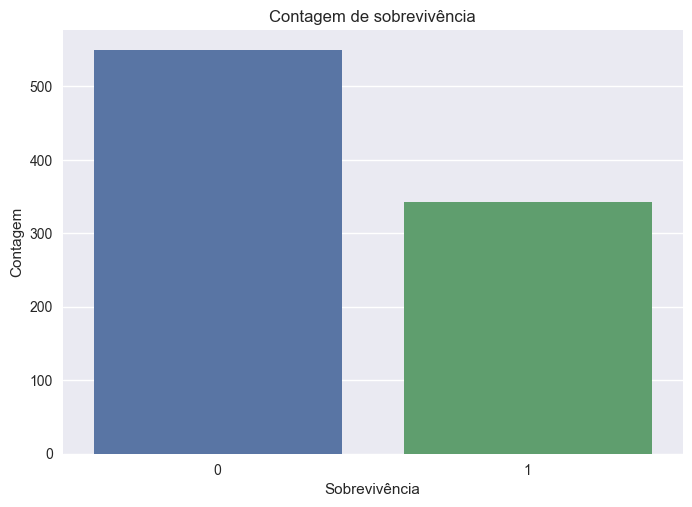

In [23]:
sns.countplot(data=df, x = 'Survived')
plt.title("Contagem de sobrevivência")
plt.xlabel('Sobrevivência')
plt.ylabel('Contagem')
plt.show()

In [24]:
print(f"Considerando o conjunto de dados, {df.Survived.value_counts()[0]/df.shape[0]*100:.2f}% dos passageiros não sobreviveram ao naufrágio :(")

Considerando o conjunto de dados, 61.62% dos passageiros não sobreviveram ao naufrágio :(


###  Pclass (classe do ticket do passageiro) 	 	 	 	 	 	

 De acordo com a descrição das features no Kaggle, os valores para esse atributo têm os seguintes significados:
 - 1 - Classe alta
 - 2 - Classe média
 - 3 - Classe baixa

 Contando a quantidade de exemplos de cada uma dessas classes, é possível observar que a maioria dos passageiros era de classe baixa:

In [25]:
df.Pclass.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

Comparando a classe dos passageiros com relação ao target para verificar se ela é relevante:

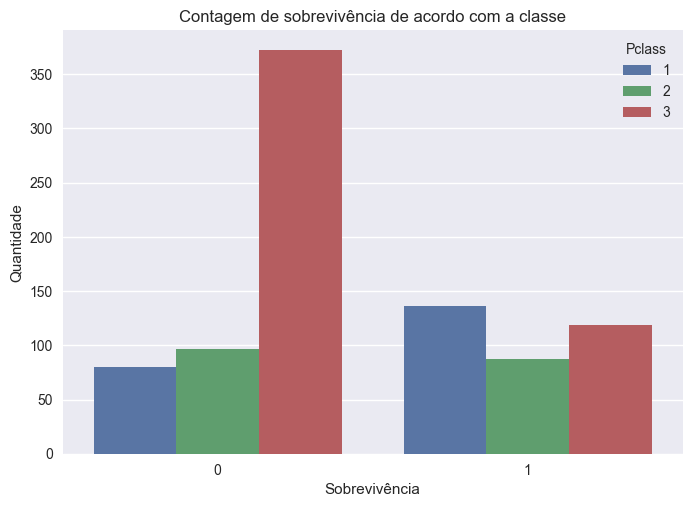

In [26]:
p = sns.countplot(data=df, x = 'Survived', hue = 'Pclass')
plt.title("Contagem de sobrevivência de acordo com a classe")
plt.xlabel("Sobrevivência")
plt.ylabel("Quantidade")
plt.show()

In [27]:
# Proporção de sobrevivência por classe

df[["Pclass", "Survived"]].groupby(['Pclass']).mean()*100

,Survived
Pclass,
1,62.962963
2,47.282609
3,24.236253


Apesar dos passageiros da terceira classe serem os mais numerosos, é possível observar tanto pela contagem de sobrevivência quanto pela proporção que esses passageiros foram os que menos sobreviveram, enquanto que os passageiros da primeira classe foram os que mais sobreviveram.

###  Sex (gênero do passageiro) 	 	 	 	

Com relação ao gênero, pode-se observar que a maioria dos passageiros eram homens:

In [28]:
df.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

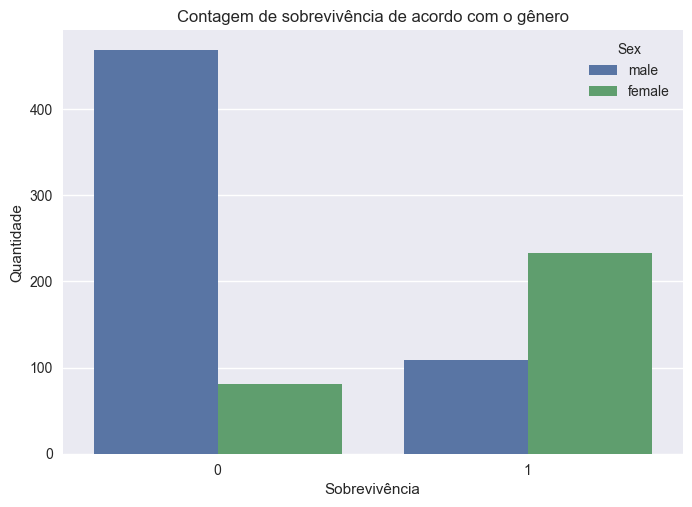

In [29]:
p = sns.countplot(data=df, x = 'Survived', hue = 'Sex')
plt.title("Contagem de sobrevivência de acordo com o gênero")
plt.xlabel("Sobrevivência")
plt.ylabel("Quantidade")
plt.show()

In [30]:
# Proporção de sobrevivência por gênero

df[["Sex", "Survived"]].groupby(['Sex']).mean()*100

,Survived
Sex,
female,74.203822
male,18.890815


Aqui também observa-se uma situação similar ao que ocorreu com a classe: os passageiros do gênero masculino, apesar de mais numerosos, tiveram uma baixa proporção de sobrevivência quando comparamos com as mulheres.

Uma outra análise interessante de ser realizada é observar as taxas de sobrevivência dependendo do gênero e também da classe:

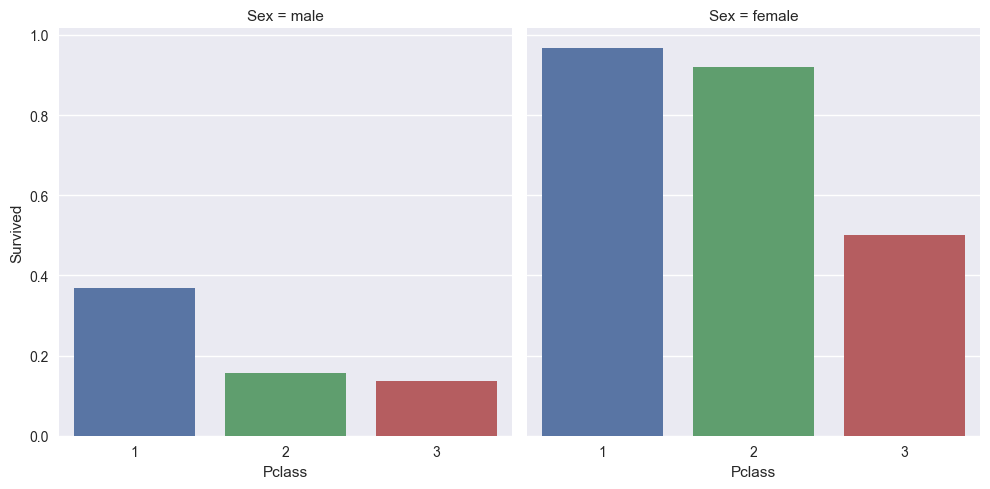

In [31]:
sns.catplot(x="Pclass", y="Survived", col="Sex", data=df,kind="bar", ci = None);

O gráfico acima permite observar que tanto para homens quanto para mulheres houve uma maior sobrevivência para os passageiros da primeira classe. Ele também permite observar que a taxa de sobrevivência das mulheres da terceira classe é mais próxima da taxa de sobrevivência dos homens da primeira classe do que das mulheres da primeira e segunda classe.

###  Age (idade do passageiro) 	 	

Observando a descrição abaixo, em média, os passageiros tinham em torno de 30 anos:

In [32]:
df['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

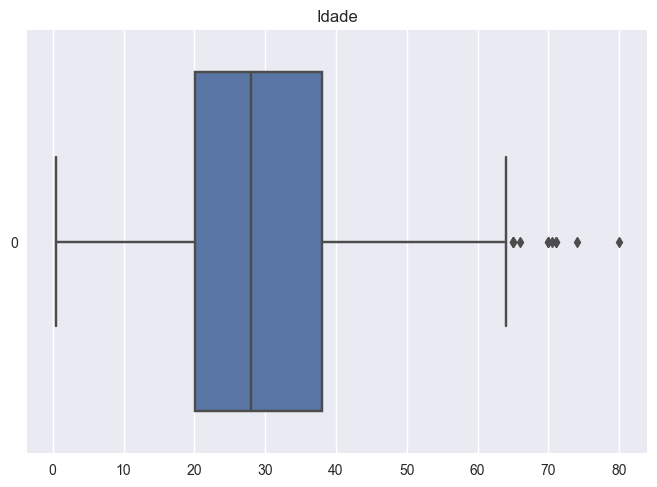

In [33]:
sns.boxplot(data = df['Age'], orient = 'h').set_title("Idade");

É possível checar também a distribuição das idades por sobrevivência. Ao tentar observar a distribuição da idade do jeito como os dados estão, será resultado em um erro porque a idade tem valores nulos. Para fazer a distribuição, há duas alternativas:
- Ignorar os nulos e ver a distribuição da idade só para os passageiros que possuem essa informação
- Substituir os valores faltantes por algum número (0, média ou mediana da idade, por exemplo)

Neste caso, os nulos serão ignorados:

In [34]:
survived_age_not_null = df.loc[(df.Survived == 1) & (df.Age.isnull()==False), 'Age']
not_survived_age_not_null = df.loc[(df.Survived == 0) & (df.Age.isnull()==False), 'Age']

c:\Users\aline\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\aline\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


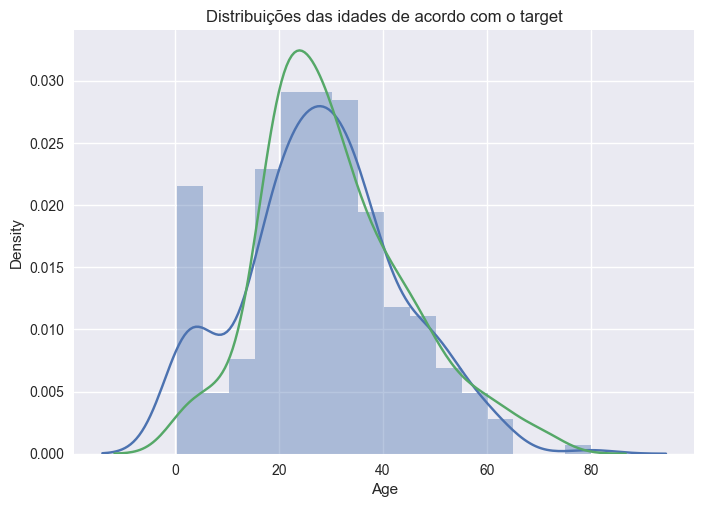

In [35]:
sns.distplot(survived_age_not_null, hist=True, label='Sobreviveu')
sns.distplot(not_survived_age_not_null, hist=False, label='Não sobreviveu')
_ = plt.title("Distribuições das idades de acordo com o target")

Ao observar as distribuições das idades entre os passageiros que sobreviveram ou não, é notável que há pico de sobrevivência para os passageiros com menos de 10 anos, indicando que crianças tiveram mais chances de sobreviverem ao naufrágio do que adultos.

### Relação entre classe e tarifa paga

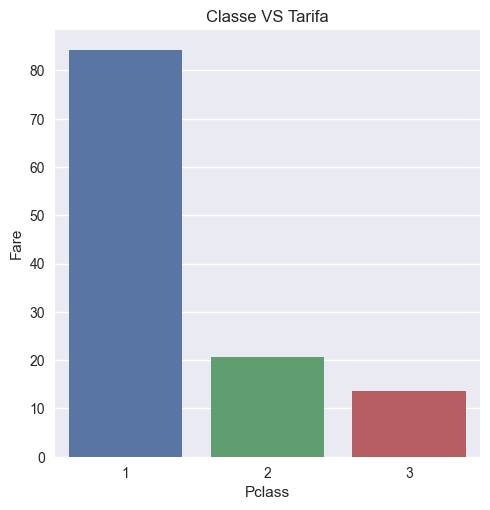

In [36]:
sns.catplot(x='Pclass', y='Fare', data= df, kind = 'bar', ci = None)
plt.title('Classe VS Tarifa');

Como esperado, o preço pago na passagem para a primeira classe é bem maior que os da 2ª e 3ª

### Relação entre tarifa paga e portão de embarque

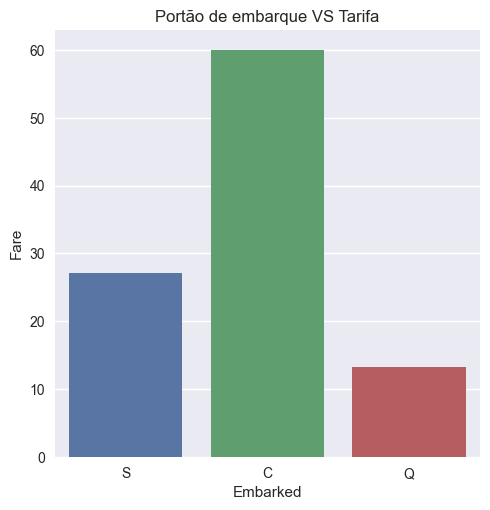

In [37]:
sns.catplot(data=df, x='Embarked', y='Fare', kind ='bar', ci = None)
plt.title('Portão de embarque VS Tarifa');

O Titanic saiu de Southampton (Inglaterra), buscou passageiros em Cherbourg-Octeville (França) e em seguida em Queenstown (Irlanda). Os passageiros que embarcaram na França pagaram bem mais que os que embarcaram nos outros portos e isto pode ser devido a maioria estar na primeira classe, como pode ser visto no gráfico abaixo:

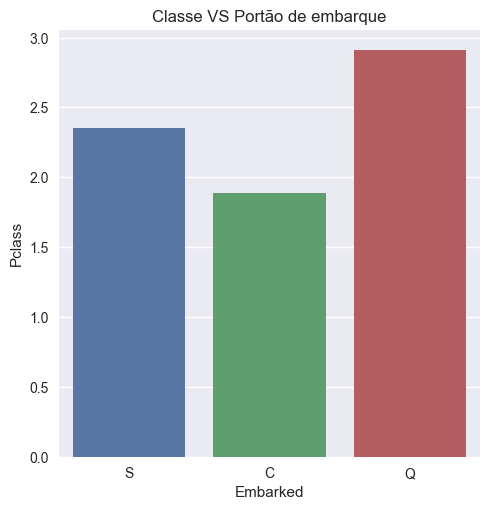

In [38]:
sns.catplot(data=df, x='Embarked', y='Pclass', kind ='bar', ci = None)
plt.title('Classe VS Portão de embarque');

### Observando se o tamanho da família influenciou na sobrevivência

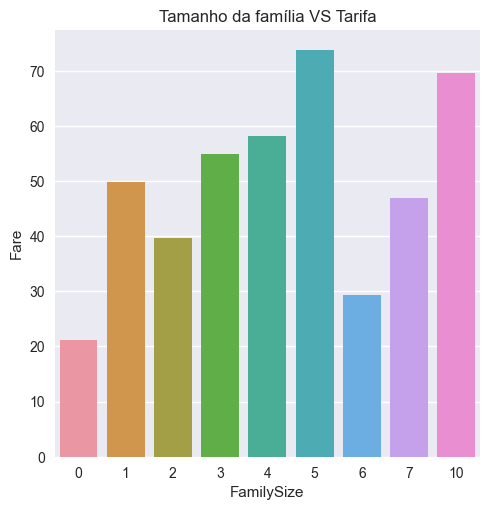

In [39]:
df['FamilySize'] = df['SibSp'] + df['Parch']
sns.catplot(data=df, x='FamilySize', y='Fare', kind='bar', ci = None)
plt.title('Tamanho da família VS Tarifa');

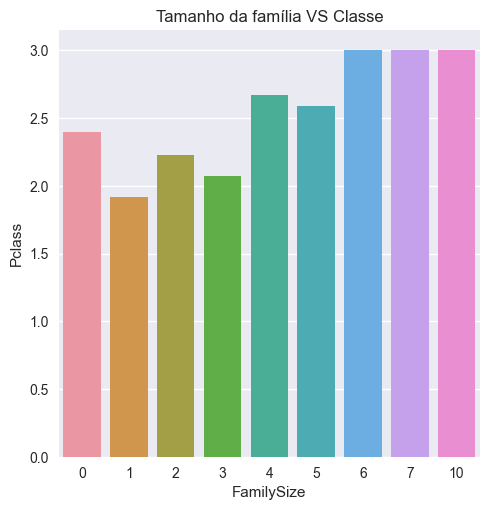

In [40]:
sns.catplot(data=df, x='FamilySize', y='Pclass', kind='bar', ci = None)
plt.title('Tamanho da família VS Classe');

Há um certo aumento a medida que a classe diminui de haver mais membros na família. Isto pode ser em razão que naquela época estava tendo uma grande migração para os EUA a fim de melhorar a vida

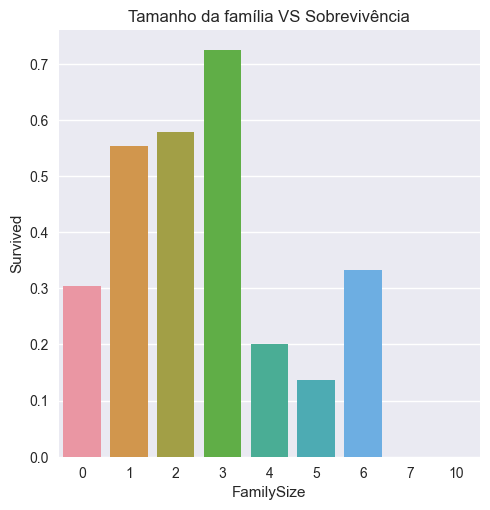

In [41]:
sns.catplot(data=df, x='FamilySize', y='Survived', kind='bar', ci = None)
plt.title('Tamanho da família VS Sobrevivência');

Famílias com até 3 membros possuiam mais chance de sobrevivência, visto que de 4 membros para cima a maioria das pessoas eram da 2 ou 3ª classe

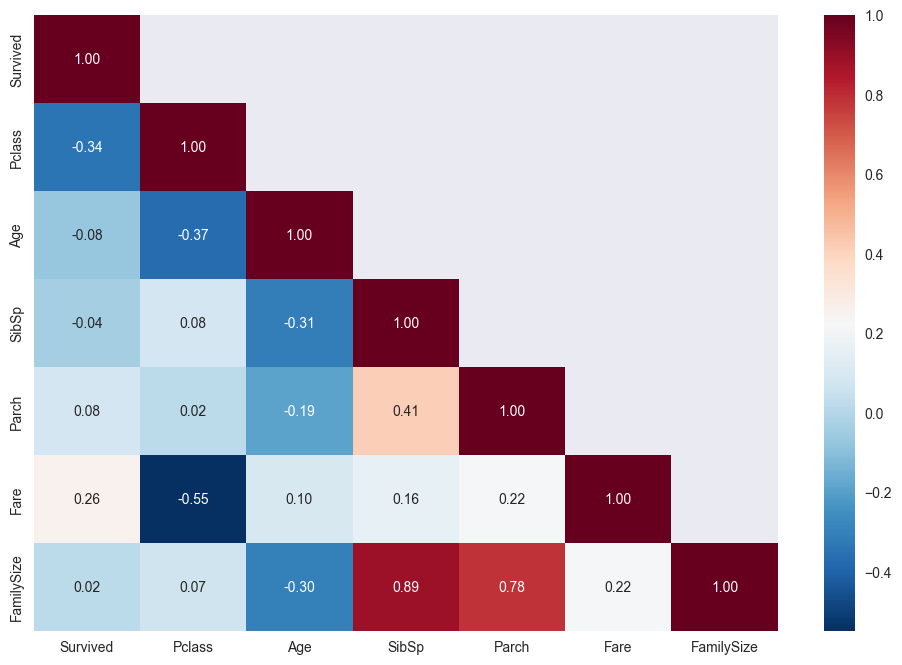

In [42]:
# Correlação entre as features

corr = df.corr()
sns.set_context(font_scale=2.0)
plt.figure(figsize=(12,8))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, 1)] = True
sns.heatmap(corr, annot=True, fmt='.2f', cmap='RdBu_r', mask=mask)
plt.show()

## Feature Engineering

Alguns algoritmos exigem que algumas transformações sejam feitas para que seja possível treinar o modelo

Algumas dessas transformações são:
- Converter features categóricas em numéricas
- Fazer normalização ou estandardização dos dados
- Fazer o tratamento de valores faltantes
- Etc...

Como exemplo, será feita a conversão de features categóricas e o tratamento de valores faltantes:

#### **Tratamento de valores faltantes (missing values)**

Como foi possível observar nas descrições acima, há casos de passageiros sem informação sobre suas idades. É possível substituir esses valores faltantes pela mediana das idades:

In [43]:
median_age = df['Age'].median() 

In [44]:
df.loc[df['Age'].isnull(), 'Age'] = median_age

#### **Conversão de features categóricas**

A feature que indica o gênero dos passageiros é categórica. Será transformada em uma feature numérica com o LabelEncoder:

In [45]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['Sex'] = encoder.fit_transform(df['Sex'])
df['Embarked'] = encoder.fit_transform(df['Embarked'])

## Treinamento

In [46]:
x = df[['Age', 'Sex', 'Pclass']]
y = df['Survived']

Será usado 75% do conjunto para treinamento e o restante para teste:

In [47]:
from sklearn.model_selection import train_test_split

# Separando os dados em treinamento e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [48]:
x_test.shape, x_train.shape

((223, 3), (668, 3))

In [49]:
# Importando o StandardScaler para normalizar os dados

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df),columns = df.columns)

Esse modelo será uma Árvore de decisão

In [50]:
from sklearn.tree import DecisionTreeClassifier

# Instanciando o classificador
model = DecisionTreeClassifier(criterion='entropy', random_state=42)

# Treinamento do modelo
model.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

## Avaliando o modelo

In [51]:
y_pred = model.predict(x_test)

In [52]:
y_pred

array([0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0], dtype=int64)

In [53]:
y_probs = model.predict_proba(x_test)

Como a métrica de avaliação do Kaggle é a acurácia, será utilizada primeiro:

In [54]:
from sklearn.metrics import accuracy_score

In [55]:
accuracy_score(y_test, y_pred)

0.7623318385650224

In [56]:
# Avaliando pela matriz de confusão

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import itertools

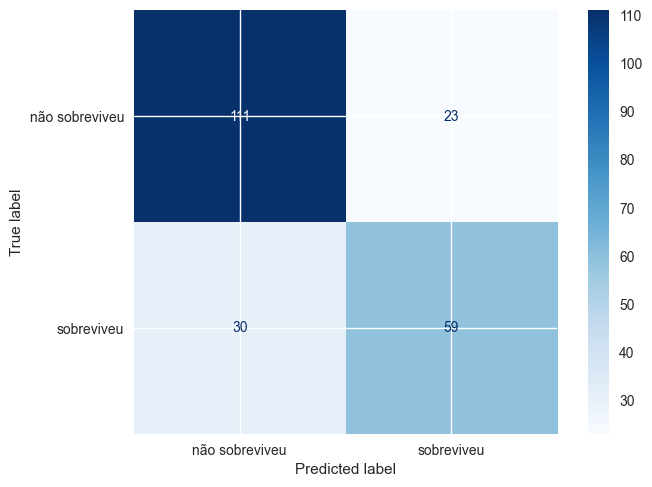

In [57]:
cnf_matrix = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(cnf_matrix, display_labels=['não sobreviveu', 'sobreviveu'])
disp.plot(cmap='Blues')

Pela matriz de confusão acima, o modelo se confundiu mais para os passageiros que sobreviveram, predizendo que eles não haviam sobrevivido.

Avaliando a precisão e recall do modelo:

In [58]:
print(classification_report(y_test, y_pred, target_names=['não sobreviveu', 'sobreviveu']))

                precision    recall  f1-score   support

não sobreviveu       0.79      0.83      0.81       134
    sobreviveu       0.72      0.66      0.69        89

      accuracy                           0.76       223
     macro avg       0.75      0.75      0.75       223
  weighted avg       0.76      0.76      0.76       223



E como seria para calcular a AUC-ROC?

In [59]:
from sklearn.metrics import roc_curve, auc

# Essa função calcula a curva roc e retorna a taxa de true positive, false positive e os thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

auc(fpr, tpr)

0.7456397786349154

Plotando a curva ROC:

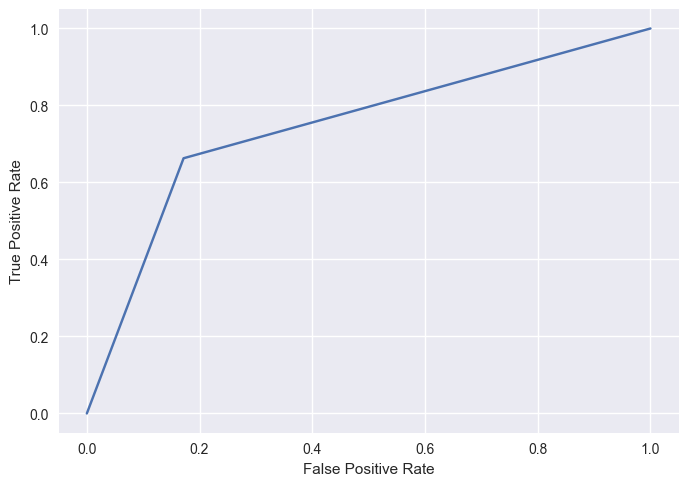

In [60]:
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Interpretabilidade

Existem diversas bibliotecas para realizar a interpretabilidade de modelos de Machine Learning. Neste caso, será utilizado o **SHAP**!

In [61]:
import shap

c:\Users\aline\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


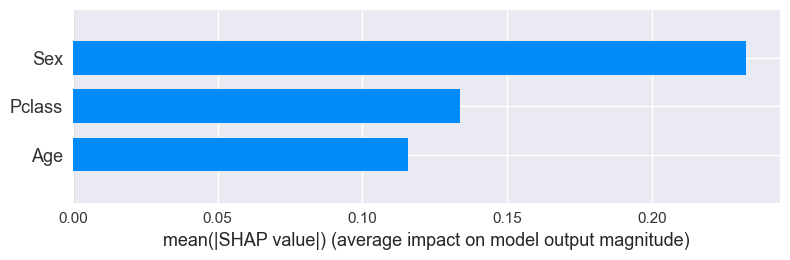

In [62]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values[1], x_train, plot_type='bar')

Pelo gráfico acima, de acordo com o modelo treinado, somente com as 3 variáveis analisadas, o gênero é a variável mais importante para determinar se uma pessoa sobreviveria ou não ao naufrágio do Titanic.

## Predição


Agora que o modelo foi avaliado e interpretado, será possível realizar as predições para o conjunto sem o target e fazer a submissão para o Kaggle

Antes de fazer as predições, será preciso fazer as mesmas transformações que do conjunto de treinamento durante a etapa de feature engineering:

In [63]:
median_age = df['Age'].median() 
submission.loc[submission['Age'].isnull(), 'Age'] = median_age

In [64]:
submission['Sex'] = encoder.fit_transform(submission['Sex'])

In [65]:
result = model.predict(submission[['Age', 'Sex', 'Pclass']])
result

array([0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0,

Para a submissão no Kaggle, além da predição, é preciso também fornecer o ID do passageiro:

In [66]:
# Transformar o array em um DataFrame para concatenar como ID

results = pd.DataFrame(list(result), columns=['Survived'])

In [67]:
submission = pd.concat([submission['PassengerId'], results],axis=1)
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,1
3,895,1
4,896,1


In [68]:
submission.to_csv("titanic_submission.csv", index=False)